D-Regler aktiv
Exponentiell wachsende Abweichung von 2 zwischen 54 und 57
dRegler failed


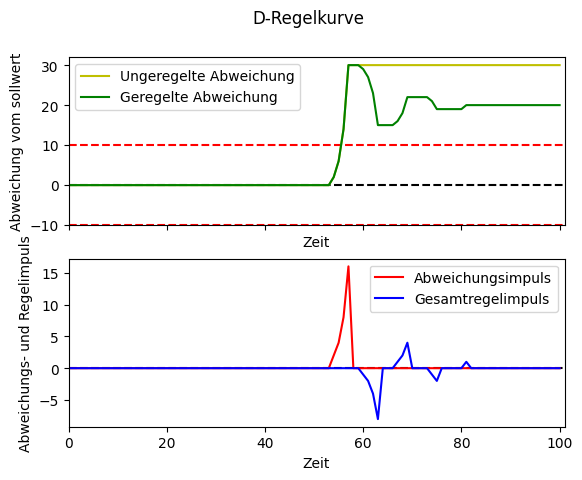

In [32]:
import random
import numpy as np
import matplotlib.pyplot as plt

Dauer               = 100                       #Dauer der Simulation in Zeitschritten
sollwert            = 0                         #Zielwert auf den geregelt werden soll
abweichungsLimits   = 10                        #Maximale Abweichung die ein Abweichungselement haben darf
graphPlusMinus      = abweichungsLimits // 5                               
abweichungsMenge    = 1
pFaktor             = 0.2
iFaktor             = 1
iLänge              = 3
dFaktor             = 0.5
dLänge              = 2

minAbweichungsLänge = 1
maxAbweichungsLänge = 10  
 
latenz              = 5                        #Muss mindestens 1 sein, keine Verzögerung wäre unmöglich
Aktiv               = "d"
    
Dauer += 1
if Dauer < maxAbweichungsLänge + 1:
    maxAbweichungsLänge = Dauer - 1

aktiveRegler = list(Aktiv.upper())
for i in aktiveRegler:
    print(f"{i}-Regler aktiv")
abweichungsImpuls = [0 for i in range(Dauer)]
    
def konstantAbweichung(abweichungsImpuls, abweichungsRange, Abweichungswert):
    print(f"Konstante Abweichung von {Abweichungswert} an {abweichungsRange[0]}")
    abweichungsImpuls[abweichungsRange[0]] = Abweichungswert
    
def linearAbweichung(abweichungsImpuls, abweichungsRange, Abweichungswert):
    Steigung = round(Abweichungswert / len(abweichungsRange))
    print(f"Linear wachsende Abweichung von {round(Steigung)} zwischen {abweichungsRange[0]} und {abweichungsRange[-1]}")
    for i in abweichungsRange:
        abweichungsImpuls[i] = round(Steigung)
    
def exponentialAbweichung(abweichungsImpuls, abweichungsRange, Abweichungswert):
    #print(f"Abweichungswert: {Abweichungswert}\nAbweichungsrange: {len(abweichungsRange)}")
    Exponent = round(np.power(abs(Abweichungswert), 1 / len(abweichungsRange)))
    print(f"Exponentiell wachsende Abweichung von {Exponent} zwischen {abweichungsRange[0]} und {abweichungsRange[-1]}")
    abweichungsRange.insert(0,0)
    
    for y, val in enumerate(abweichungsRange[1:]):  
        #print(Exponent, len(abweichungsRange[:y])+1)
        abweichungsImpuls[val] = round(Exponent ** (len(abweichungsRange[:y])+1))
        if Abweichungswert < 0:
            abweichungsImpuls[val] = abweichungsImpuls[val] * -1
            
for i in range(len(abweichungsStarts)):
    abweichungsRange    = list(range(abweichungsStarts[i],abweichungsStarts[i]+random.randint(minAbweichungsLänge,maxAbweichungsLänge)))
    Abweichungswert     = 0
    while Abweichungswert == 0:
        Abweichungswert     = random.randint(sollwert - abweichungsLimits, sollwert + abweichungsLimits)
                
    random.choice([konstantAbweichung,linearAbweichung,exponentialAbweichung])(abweichungsImpuls, abweichungsRange, Abweichungswert)
    
def Abweichung(Dauer,abweichungsLimits,abweichungsMenge, sollwert,minAbweichungsLänge, maxAbweichungsLänge):
    abweichungsImpuls = [0 for i in range(Dauer)]
    
    abweichungsStarts = sorted([random.choice(range(Dauer - maxAbweichungsLänge)) for i in range(abweichungsMenge)])
    
        
    for i in range(len(abweichungsStarts)):
        abweichungsRange    = list(range(abweichungsStarts[i],abweichungsStarts[i]+random.randint(minAbweichungsLänge,maxAbweichungsLänge)))
        Abweichungswert     = random.randint(sollwert - abweichungsLimits, sollwert + abweichungsLimits)
        while Abweichungswert == 0:
            Abweichungswert     = random.randint(sollwert - abweichungsLimits, sollwert + abweichungsLimits)

        random.choice([konstantAbweichung,linearAbweichung,exponentialAbweichung])(abweichungsImpuls, abweichungsRange, Abweichungswert)
    return abweichungsImpuls


abweichungsKurve = [sollwert]
for i in range(Dauer):
    abweichungsKurve.append(abweichungsKurve[i] + abweichungsImpuls[i])
abweichungsKurve = abweichungsKurve[1:]
GeregelteAbweichung = [abweichungsKurve[0]]
GesamtRegelImpuls = [0 for i in range(latenz)]
pListe = [0 for i in range(latenz)]
iListe = [0 for i in range(latenz)]
dListe = [0 for i in range(latenz)]
def pRegler(sollwert, Wert, Kp): #Nimmt sollwert und aktuellen Wert
    return (sollwert - Wert) * Kp

def iRegler(GeregelteAbweichung, Ki, iLänge):
    try:
        return (-1 * np.trapz(GeregelteAbweichung[-iLänge:]) * Ki) / (len(GeregelteAbweichung))
    except:
        print("dRegler failed")
        return 0

def dRegler(GeregelteAbweichung, Kd, dLänge):
    try:
        val = (-1 * np.diff(GeregelteAbweichung[-dLänge:]) * Kd)[-1]
        return val
    except:
        print("dRegler failed")
        return 0
    
for i in range(Dauer):
    gesamtRegelImpuls = 0
    if "P" in aktiveRegler:
        pv = pRegler(sollwert, GeregelteAbweichung[i], pFaktor)
        pListe.append(round(pv))
        gesamtRegelImpuls += pv 
    if "I" in aktiveRegler:
        iv = iRegler(GeregelteAbweichung, iFaktor, iLänge)
        iListe.append(round(iv))
        gesamtRegelImpuls += iv
    if "D" in aktiveRegler:
        #print(f"Geregelte Abweichung: {GeregelteAbweichung[i]}")
        dv = dRegler(GeregelteAbweichung, dFaktor, dLänge)
        dListe.append(round(dv))
        gesamtRegelImpuls += dv
    GesamtRegelImpuls.append(round(gesamtRegelImpuls))
        
    GeregelteAbweichung.append(GeregelteAbweichung[i] + abweichungsImpuls[i] + GesamtRegelImpuls[i]) #Erstellt die geregelte abweichungsKurve aus dem letzten Wert + Wert der im nächsten Schritt abgewichen wird + dem Regelimpuls
        
GeregelteAbweichung.pop(0)
    
werte = GeregelteAbweichung + GesamtRegelImpuls + abweichungsImpuls
yMax = max(werte) + graphPlusMinus
yMin = min(werte) - graphPlusMinus
    
    
#Plottet den Graphen

fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True)
plotSelector = ax2
ax1.set_ylabel("Abweichung vom sollwert")
ax2.set_ylabel("Abweichungs- und Regelimpuls")
    
            
ax1.axis([0,Dauer,yMin,yMax]) 

ax1.set_xlabel("Zeit")

ax1.axhline(y=sollwert, color='black', linestyle=('dashed'))
ax1.axhline(y=sollwert-abweichungsLimits, color='red', linestyle=('dashed'))
ax1.axhline(y=sollwert+abweichungsLimits, color='red', linestyle=('dashed'))

ax1.plot(list(range(Dauer)),abweichungsKurve, color="y", label="Ungeregelte Abweichung")
ax1.plot(list(range(Dauer)),GeregelteAbweichung[:Dauer], color="g", label="Geregelte Abweichung")
    
    
    
plotSelector.set_xlabel("Zeit")

plotSelector.axhline(y=sollwert, color='black', linestyle=('dashed'))

plotSelector.plot(list(range(Dauer)),abweichungsImpuls, color="r", label="Abweichungsimpuls")
plotSelector.plot(list(range(Dauer)),GesamtRegelImpuls[:Dauer], color="b", label="Gesamtregelimpuls") 


fig.suptitle(f"{''.join(aktiveRegler)}-Regelkurve")
ax1.legend()
plotSelector.legend()
plt.show()

